In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [5]:
# 7.(a)
NA_PATH = "column_2C.dat"
NDS_PATH = "column_3C.dat"

NAMES = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", 
         "sacral_slope", "pelvic_radius", "grade_of_spondylolisthesis", "label"]

na_df = pd.read_csv(NA_PATH, header=None, sep="\s+", names=NAMES)
na_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,label
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


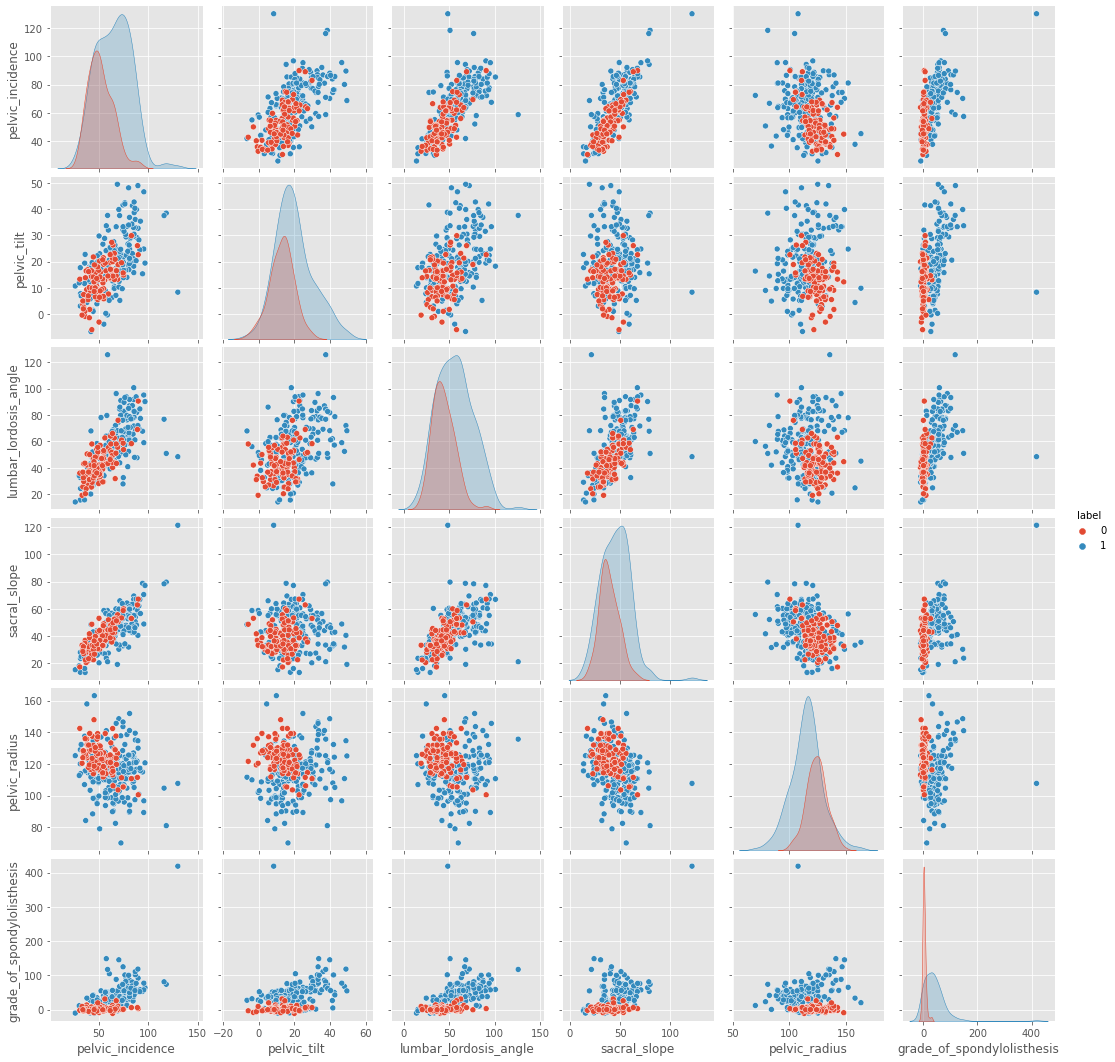

In [6]:
# 7.(b).i
# In this problem, I create 36 figures and only 30 figures are useful. 
#The figures in diagonal is the relationship between the independent variables themselves.

na_df.loc[na_df["label"] == "NO", "label"] = 0
na_df.loc[na_df["label"] == "AB", "label"] = 1

# create scatter plot
pair_plot = sns.pairplot(na_df, hue="label", diag_kind="kde")

plt.show()

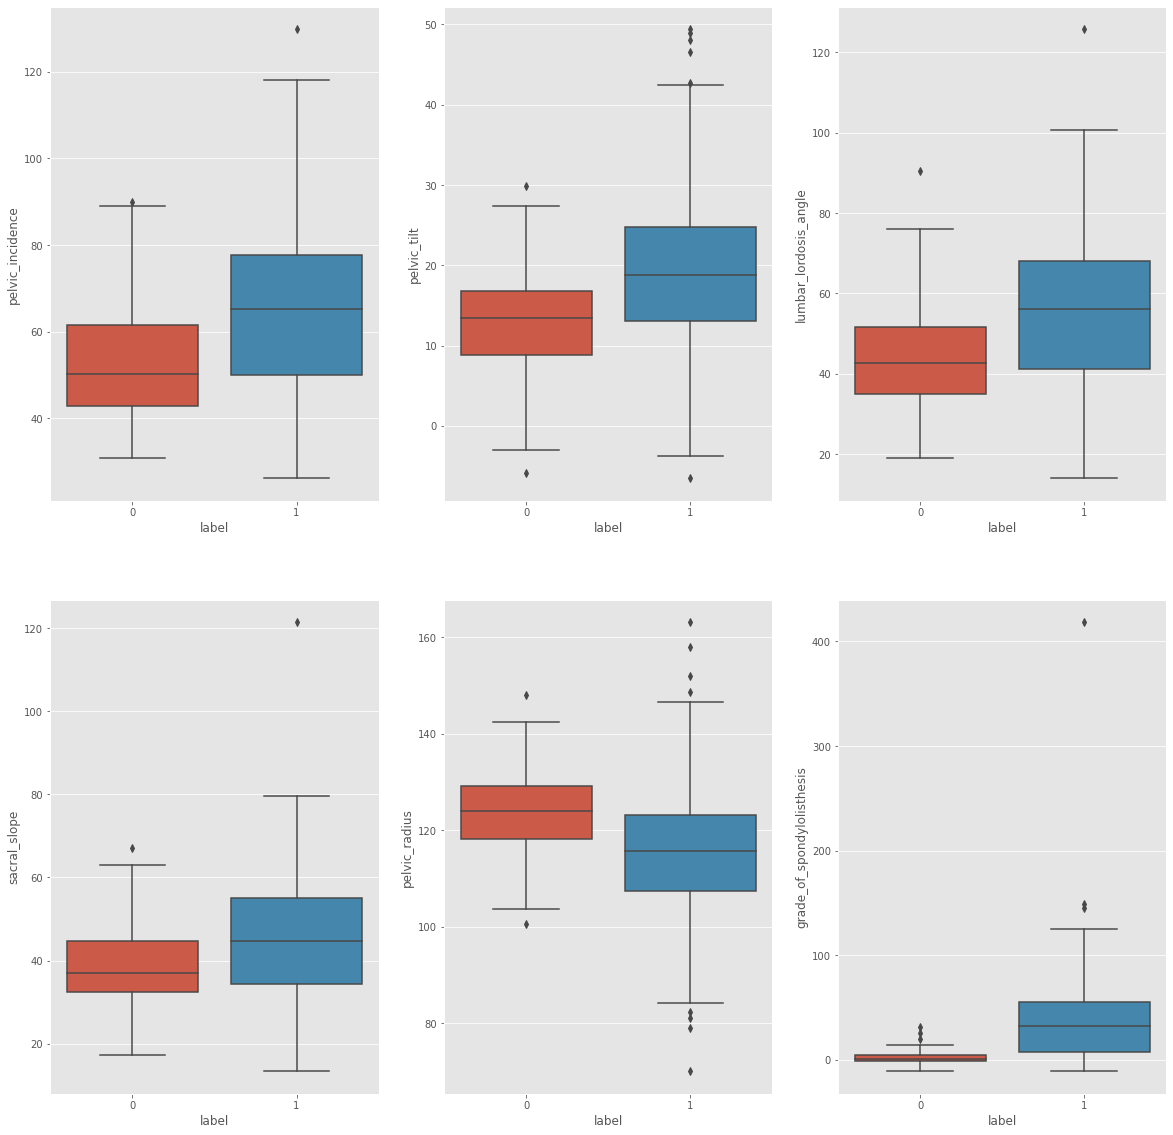

In [7]:
# 7.(b).ii

fig, axes = plt.subplots(2, 3, figsize=(20, 20))

for i in range(6):
    sns.boxplot(x="label", y=NAMES[i], data=na_df, ax=axes[i // 3, i % 3])

plt.show()

In [8]:
# 7.(b).iii

train_set = pd.concat([na_df[na_df["label"] == 0].iloc[0:70, :],
                          na_df[na_df["label"] == 1].iloc[0:140, :]],
                          ignore_index=True)

test_set = pd.concat([na_df[na_df["label"] == 0].iloc[70:, :],
                          na_df[na_df["label"] == 1].iloc[140:, :]],
                          ignore_index=True)

print("The training set has shape ", train_set.shape)
print("The test set has shape ", test_set.shape)

train_set

The training set has shape  (210, 7)
The test set has shape  (100, 7)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,label
0,38.51,16.96,35.11,21.54,127.63,7.99,0
1,54.92,18.97,51.60,35.95,125.85,2.00,0
2,44.36,8.95,46.90,35.42,129.22,4.99,0
3,48.32,17.45,48.00,30.87,128.98,-0.91,0
4,45.70,10.66,42.58,35.04,130.18,-3.39,0
...,...,...,...,...,...,...,...
205,77.12,30.35,77.48,46.77,110.61,82.09,1
206,88.02,39.84,81.77,48.18,116.60,56.77,1
207,83.40,34.31,78.42,49.09,110.47,49.67,1
208,72.05,24.70,79.87,47.35,107.17,56.43,1


In [9]:
# 7.(c)i Write code for k-nearest neighbors with Euclidean metric
from heapq import heappop, heappush
from sklearn.metrics import confusion_matrix

class KNNClassifier:
    
    def __init__(self, K=6, metric='euclidean', p=2, weighted=False):
        '''
        K : int, the number of K neighbors to poll
        metric : string, type of distance as metric
        p : int, the order of norm
        weighted : bool, in weighted mode or not
        '''
        self.K = K
        self.metric = metric
        self.weighted = weighted
        self.p = p
    
    def euclidean_dist(self, u, v):
        u = u.to_numpy()
        v = v.to_numpy()
        return np.linalg.norm(u - v)
    
    def minkowski_dist(self, u, v, p):
        u = u.to_numpy()
        v = v.to_numpy()
        return np.linalg.norm(u - v, ord=p)
    
    def chebyshev_dist(self, u, v):
        u = u.to_numpy()
        v = v.to_numpy()
        return np.max(np.abs(u - v))

    def mahalanobis_dist(self, u, v, covI):
        u = u.to_numpy()
        v = v.to_numpy()
        delta = u - v
        #m = np.dot(np.dot(delta, covI), delta.T)
        m = delta@covI@delta.T
        return np.sqrt(m);
        
    def fit(self, trainX, trainY, testX, testY):
        '''
        trainX: dataframe, training sample features
        trainY : data_frame, training sample labels
        testX: dataframe, test sample features
        testY : data_frame, test sample labels
        
        return: a dictionary contains results and paramters of model
        '''
        
        predictions = []
        
        # calculate the covariance matrix if using Mahalanobisa as metric
        if self.metric == 'mahalanobis':
            covI = np.linalg.inv(trainX.cov())
        
        for i in range(testX.shape[0]):
            # create a list as the container of a max heap with size K
            max_heap = []
            u = testX.iloc[i]
            for j in range(trainX.shape[0]):
                v = trainX.iloc[j]
                if self.metric == 'manhattan':
                    dist = self.minkowski_dist(u, v, 1)
                elif self.metric == 'minkowski':
                    dist = self.minkowski_dist(u, v, self.p)
                elif self.metric == 'chebyshev':
                    dist = self.chebyshev_dist(u, v)
                elif self.metric == 'mahalanobis':
                    dist = self.mahalanobis_dist(u, v, covI)
                else:
                    # dist = self.euclidean_dist(u, v)
                    dist = self.minkowski_dist(u, v, 2)
                heappush(max_heap, (-dist, j))
                if len(max_heap) > self.K:
                    heappop(max_heap)
            
            # majority polling
            vote = 0
            while len(max_heap) > 0:
                dist, idx = heappop(max_heap)
                # non-weighted poll
                if not self.weighted:
                    vote += 1 if trainY[idx] == 0 else -1
                # weighted poll
                else:
                    vote += (1 / -dist) if trainY[idx] == 0 else (1 / dist)
            
            predictions.append(0 if vote >= 0 else 1)
        
        # error rate calculation, note that convert Series to list
        error_rate = (predictions != testY.values).sum() / len(testY)
        
        # confusion matrix, note that the datatype of two vector MUST be the same
        confusion_mat = confusion_matrix(testY.to_numpy('int64'), np.array(predictions))
        
        return {
            'error_rate' : error_rate,
            'confusion_mat' : confusion_mat,
            'k' : self.K,
            'metric' : self.metric,
            'weighted' : self.weighted
        }

trainX = train_set.iloc[:, :-1]
trainY = train_set.iloc[:, -1]
testX = test_set.iloc[:, :-1]
testY = test_set.iloc[:, -1]

clf = KNNClassifier()
result_params = clf.fit(trainX, trainY, testX, testY)
result_params

{'error_rate': 0.08,
 'confusion_mat': array([[22,  8],
        [ 0, 70]], dtype=int64),
 'k': 6,
 'metric': 'euclidean',
 'weighted': False}

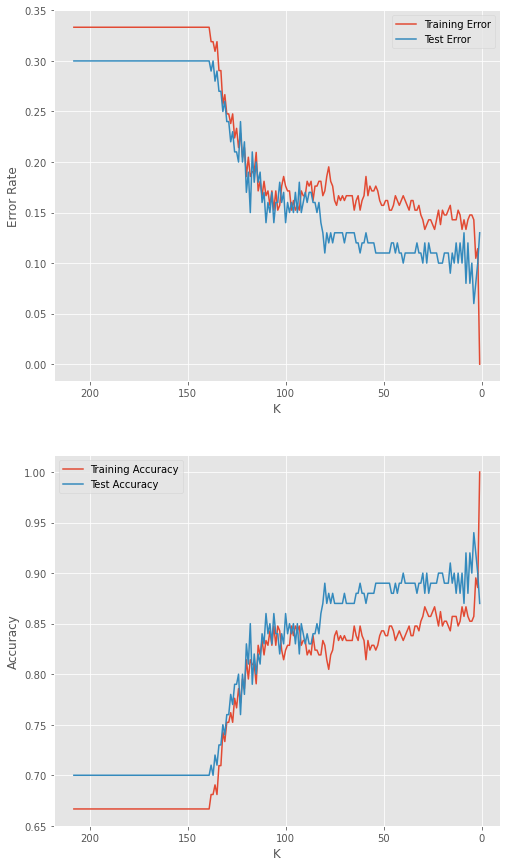

{'confusion_mat': array([[25,  5],
       [ 1, 69]], dtype=int64),
 'error_rate': 0.06,
 'k': 4,
 'metric': 'euclidean',
 'weighted': False}


In [54]:
# 7.(c).ii
best = {
    'error_rate' : float('inf'),
    'confusion_mat' : None,
    'k' : 0,
    'metric' : "",
    'weighted' : False
}

k_step = -1
k_values = range(208, 0, k_step)
train_errors, test_errors = [], []

# iterate k from 208 (inclusive) to 0 (exclusive) with set step
for k in k_values:
    clf = KNNClassifier(K=k)
    
    train_result = clf.fit(trainX, trainY, trainX, trainY)
    train_errors.append(train_result['error_rate'])
    
    test_result = clf.fit(trainX, trainY, testX, testY)
    if (test_result['error_rate'] < best['error_rate']):
        best = test_result
    test_errors.append(test_result['error_rate'])

# plot curve of error/accuracy rate versus k
fig, axes = plt.subplots(2, 1, figsize=(8, 15))

# error curve
axes[0].plot(k_values, train_errors, label="Training Error")
axes[0].plot(k_values, test_errors, label="Test Error")
axes[0].invert_xaxis()
axes[0].set_xlabel("K")
axes[0].set_ylabel("Error Rate")
axes[0].legend()

# accuracy curve
axes[1].plot(k_values, list(map((lambda x: 1 - x), train_errors)), label="Training Accuracy")
axes[1].plot(k_values, list(map((lambda x: 1 - x), test_errors)), label="Test Accuracy")
axes[1].invert_xaxis()
axes[1].set_xlabel("K")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

import pprint
pprint.pprint(best)

In [46]:
# Based on the figures above, the lowest point of test error is k=4. 
# The following code will calculate the value of k in detail. 
# In addition, the best performance occured when k=1

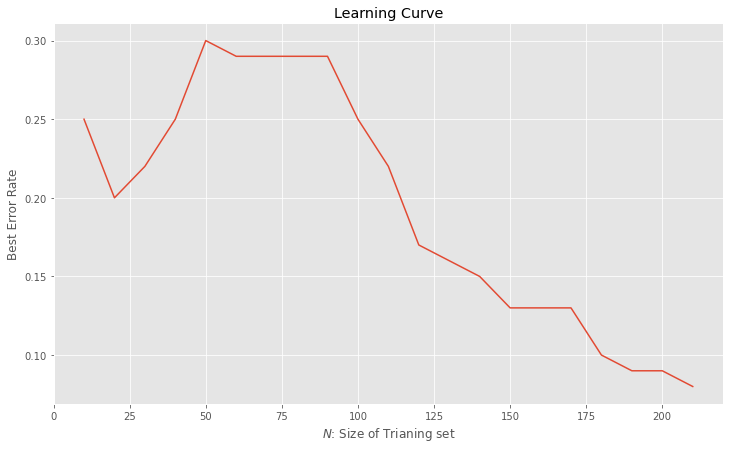

In [12]:
# 7.(c).iii
N_values = range(10, 211, 10)

best_Ks = []
best_Errors = []

for N in N_values:
    # truncate train set
    truncated_train_set = pd.concat([train_set[train_set["label"] == 0].iloc[0: N // 3, :], 
                                    train_set[train_set["label"] == 1].iloc[0: N - N // 3, :]],
                                    ignore_index=True)
    
    trainX = truncated_train_set.iloc[:, :-1]
    trainY = truncated_train_set.iloc[:, -1]
    
    best_error = float('inf')
    best_k = 0
    for k in range(1, N, 5):
        clf = KNNClassifier(K=k)
        
        result = clf.fit(trainX, trainY, testX, testY)
        if (result['error_rate'] < best_error):
            best_k = result['k']
            best_error = result['error_rate']
    
    best_Ks.append(best_k)
    best_Errors.append(best_error)
    
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(N_values, best_Errors)
axes.set_xlabel('$N$: Size of Trianing set')
axes.set_ylabel('Best Error Rate')
axes.set_title('Learning Curve')
plt.show()

In [15]:
# 7.(d).i.A

# define a function to iterate models with various k values
def investigate_models(train_set, test_set, metric, k_values, weighted=False):
    # use the whole train set
    trainX = train_set.iloc[:, :-1]
    trainY = train_set.iloc[:, -1]
    
    # split features and labels in test set
    testX = test_set.iloc[:, :-1]
    testY = test_set.iloc[:, -1]
    
    error_vals = []
    best_options = []
    
    for k in k_values:
        clf = KNNClassifier(K=k, metric=metric, weighted=weighted)
        result = clf.fit(trainX, trainY, testX, testY)
        if (len(best_options) == 0 or result['error_rate'] <= best_options[-1]['error_rate']):
            if (len(best_options) != 0 and result['error_rate'] < best_options[-1]['error_rate']):
                best_options = []
            best_options.append(result)
        error_vals.append(result['error_rate'])
    
    return (error_vals, best_options)


In [18]:
k_values = range(1, 200, 5)
manhat_error_vals, manhat_best_options = investigate_models(train_set, test_set, 'manhattan', k_values)

In [20]:
manhat_error_vals
k_values
manhat_best_options

[{'error_rate': 0.11,
  'confusion_mat': array([[22,  8],
         [ 3, 67]], dtype=int64),
  'k': 6,
  'metric': 'manhattan',
  'weighted': False},
 {'error_rate': 0.11,
  'confusion_mat': array([[20, 10],
         [ 1, 69]], dtype=int64),
  'k': 11,
  'metric': 'manhattan',
  'weighted': False},
 {'error_rate': 0.11,
  'confusion_mat': array([[20, 10],
         [ 1, 69]], dtype=int64),
  'k': 26,
  'metric': 'manhattan',
  'weighted': False}]

In [21]:
#The above results show that when K = 6 or K = 11 or K = 26, Manhattan Distance has the best performance.

In [22]:
#7.(d).i.B

logp_values = np.linspace(0.1, 1, 10)
p_values = np.logspace(0.1, 1, 10)

# use the whole train set
trainX = train_set.iloc[:, :-1]
trainY = train_set.iloc[:, -1]

minik_error_vals = []
minik_best_options = []

for p in p_values:
    clf = KNNClassifier(K=6, metric='minkowski', p=p)
    result = clf.fit(trainX, trainY, testX, testY)
    if (len(minik_best_options) == 0 or result['error_rate'] <= minik_best_options[-1]['error_rate']):
        if (len(minik_best_options) != 0 and result['error_rate'] < minik_best_options[-1]['error_rate']):
            minik_best_options = []
        minik_best_options.append(result)
    minik_error_vals.append(result['error_rate'])

p_analysis = {
    'K' : [6 for i in range(len(p_values))],
    'p' : p_values,
    'log10(p)' : logp_values,
    'Error_Rate' : minik_error_vals
}

p_analysis = pd.DataFrame(p_analysis)
p_analysis

,K,p,log10(p),Error_Rate
0,6,1.258925,0.1,0.09
1,6,1.584893,0.2,0.09
2,6,1.995262,0.3,0.08
3,6,2.511886,0.4,0.08
4,6,3.162278,0.5,0.08
5,6,3.981072,0.6,0.06
6,6,5.011872,0.7,0.07
7,6,6.309573,0.8,0.08
8,6,7.943282,0.9,0.09
9,6,10.000000,1.0,0.09


In [24]:
# The result shows that when K = 6 and p = 3.981072, the error rate is 0.06 which is minimun.

In [25]:
#7.(d).i.C
k_values = range(1, 200, 5)
cheby_error_vals, cheby_best_options = investigate_models(train_set, test_set, 'chebyshev', k_values)

In [26]:
cheby_error_vals
k_values
cheby_best_options

[{'error_rate': 0.08,
  'confusion_mat': array([[22,  8],
         [ 0, 70]], dtype=int64),
  'k': 16,
  'metric': 'chebyshev',
  'weighted': False}]

In [27]:
# The above results show that when K = 16, Chebyshev Distance has the best performance.

In [28]:
#7.(d).ii
k_values = range(1, 200, 5)
mahal_error_vals, mahal_best_options = investigate_models(train_set, test_set, 'mahalanobis', k_values)

In [30]:
mahal_error_vals
k_values
mahal_best_options

[{'error_rate': 0.17,
  'confusion_mat': array([[18, 12],
         [ 5, 65]], dtype=int64),
  'k': 1,
  'metric': 'mahalanobis',
  'weighted': False},
 {'error_rate': 0.17,
  'confusion_mat': array([[19, 11],
         [ 6, 64]], dtype=int64),
  'k': 6,
  'metric': 'mahalanobis',
  'weighted': False}]

In [31]:
# The above results show that when K = 1 or K = 6, Mahalanobis Distance has the best performance.

In [32]:
# summarize best performance(s) of each each matrix in a table 
metrics_summary = {
    'Index' : ['Optimal K', 'Error Rate'],
}

for metric, best_opts in zip(['manhattan', 'minkowski', 'chebyshev', 'mahalanobis'],
                             [manhat_best_options, minik_best_options, cheby_best_options, mahal_best_options]):
    metrics_summary[metric] = [[res['k'] for res in best_opts],
                               best_opts[0]['error_rate']]

metrics_summary = pd.DataFrame(metrics_summary)
metrics_summary.set_index('Index')
metrics_summary

,Index,manhattan,minkowski,chebyshev,mahalanobis
0,Optimal K,"[6, 11, 26]",[6],[16],"[1, 6]"
1,Error Rate,0.11,0.06,0.08,0.17


In [34]:
#7.(e)
k_values = range(1, 200, 5)

error_series = {}
best_perform = {}

for metric in ['euclidean', 'manhattan', 'chebyshev']:
    error_vals, best_options = investigate_models(train_set, test_set, metric, k_values, weighted=True)
    best_perform[metric] = best_options
    error_series[metric] = error_vals

In [40]:
weighted_polling_summary = {
    'Index' : ['Optimal K', 'Error Rate'],
}
for metric in ['euclidean', 'manhattan', 'chebyshev']:
    weighted_polling_summary[metric.capitalize()] = [[res['k'] for res in best_perform[metric]], 
                                                     best_perform[metric][0]['error_rate']]

In [41]:
weighted_polling_summary = pd.DataFrame(weighted_polling_summary)
weighted_polling_summary.set_index('Index')
weighted_polling_summary

,Index,Euclidean,Manhattan,Chebyshev
0,Optimal K,[6],[26],"[16, 31, 36, 41, 61]"
1,Error Rate,0.1,0.1,0.11


In [43]:
# The above results show that when K = 6, Euclidean Distance has the best performance.
# When K = 26, Manhattan Distance has the best performance.
# When K = 16 or 31 or 36 or 41 or 61, Chebyshev Distance has the best performance.

In [47]:
# 7.(e)
# In the 7.(c).ii, the lowest error rate is 0 when K = 1. 
# In this case, when classifying a sample from traning set, the only neighbor is itself. Thus, the classification will be always correct.